##### Copyright 2020 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Recommending movies: ranking

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/recommenders/examples/basic_ranking"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/recommenders/blob/main/docs/examples/basic_ranking.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/recommenders/blob/main/docs/examples/basic_ranking.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/recommenders/docs/examples/basic_ranking.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>



Real-world recommender systems are often composed of two stages:

1. The retrieval stage is responsible for selecting an initial set of hundreds of candidates from all possible candidates. The main objective of this model is to efficiently weed out all candidates that the user is not interested in. Because the retrieval model may be dealing with millions of candidates, it has to be computationally efficient.
2. The ranking stage takes the outputs of the retrieval model and fine-tunes them to select the best possible handful of recommendations. Its task is to narrow down the set of items the user may be interested in to a shortlist of likely candidates.

We're going to focus on the second stage, ranking. If you are interested in the retrieval stage, have a look at our [retrieval](basic_retrieval) tutorial.

In this tutorial, we're going to:

1. Get our data and split it into a training and test set.
2. Implement a ranking model.
3. Fit and evaluate it.


## Imports


Let's first get our imports out of the way.

In [1]:
!pip install -q tensorflow-recommenders
!pip install -q --upgrade tensorflow-datasets

In [2]:
import os
import pprint
import tempfile

from typing import Dict, Text

import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

In [3]:
import tensorflow_recommenders as tfrs

## Preparing the dataset

We're going to use the same data as the [retrieval](basic_retrieval) tutorial. This time, we're also going to keep the ratings: these are the objectives we are trying to predict.

In [4]:
ratings = tfds.load("movielens/100k-ratings", split="train")

ratings = ratings.map(lambda x: {
    "movie_title": x["movie_title"],
    "user_id": x["user_id"],
    "user_rating": x["user_rating"]
})

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling C:\Users\stefa\tensorflow_datasets\movielens\100k-ratings\0.1.1.incompleteP9UZ1P\movielens-train.tfr…

Dataset movielens downloaded and prepared to C:\Users\stefa\tensorflow_datasets\movielens\100k-ratings\0.1.1. Subsequent calls will reuse this data.


As before, we'll split the data by putting 80% of the ratings in the train set, and 20% in the test set.

In [5]:
tf.random.set_seed(42)
shuffled = ratings.shuffle(100_000, seed=42, reshuffle_each_iteration=False)

train = shuffled.take(80_000)
test = shuffled.skip(80_000).take(20_000)

Let's also figure out unique user ids and movie titles present in the data. 

This is important because we need to be able to map the raw values of our categorical features to embedding vectors in our models. To do that, we need a vocabulary that maps a raw feature value to an integer in a contiguous range: this allows us to look up the corresponding embeddings in our embedding tables.

In [6]:
movie_titles = ratings.batch(1_000_000).map(lambda x: x["movie_title"])
user_ids = ratings.batch(1_000_000).map(lambda x: x["user_id"])

unique_movie_titles = np.unique(np.concatenate(list(movie_titles)))
unique_user_ids = np.unique(np.concatenate(list(user_ids)))

## Implementing a model

### Architecture

Ranking models do not face the same efficiency constraints as retrieval models do, and so we have a little bit more freedom in our choice of architectures.

A model composed of multiple stacked dense layers is a relatively common architecture for ranking tasks. We can implement it as follows:

In [7]:
class RankingModel(tf.keras.Model):

  def __init__(self):
    super().__init__()
    embedding_dimension = 32

    # Compute embeddings for users.
    self.user_embeddings = tf.keras.Sequential([
      tf.keras.layers.StringLookup(
        vocabulary=unique_user_ids, mask_token=None),
      tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dimension)
    ])

    # Compute embeddings for movies.
    self.movie_embeddings = tf.keras.Sequential([
      tf.keras.layers.StringLookup(
        vocabulary=unique_movie_titles, mask_token=None),
      tf.keras.layers.Embedding(len(unique_movie_titles) + 1, embedding_dimension)
    ])

    # Compute predictions.
    self.ratings = tf.keras.Sequential([
      # Learn multiple dense layers.
      tf.keras.layers.Dense(256, activation="relu"),
      tf.keras.layers.Dense(64, activation="relu"),
      # Make rating predictions in the final layer.
      tf.keras.layers.Dense(1)
  ])
    
  def call(self, inputs):

    user_id, movie_title = inputs

    user_embedding = self.user_embeddings(user_id)
    movie_embedding = self.movie_embeddings(movie_title)

    return self.ratings(tf.concat([user_embedding, movie_embedding], axis=1))

This model takes user ids and movie titles, and outputs a predicted rating:

In [8]:
RankingModel()((["42"], ["One Flew Over the Cuckoo's Nest (1975)"]))

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.00206061]], dtype=float32)>

### Loss and metrics

The next component is the loss used to train our model. TFRS has several loss layers and tasks to make this easy.

In this instance, we'll make use of the `Ranking` task object: a convenience wrapper that bundles together the loss function and metric computation. 

We'll use it together with the `MeanSquaredError` Keras loss in order to predict the ratings.

In [9]:
task = tfrs.tasks.Ranking(
  loss = tf.keras.losses.MeanSquaredError(),
  metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

The task itself is a Keras layer that takes true and predicted as arguments, and returns the computed loss. We'll use that to implement the model's training loop.

### The full model

We can now put it all together into a model. TFRS exposes a base model class (`tfrs.models.Model`) which streamlines bulding models: all we need to do is to set up the components in the `__init__` method, and implement the `compute_loss` method, taking in the raw features and returning a loss value.

The base model will then take care of creating the appropriate training loop to fit our model.

In [10]:
class MovielensModel(tfrs.models.Model):

  def __init__(self):
    super().__init__()
    self.ranking_model: tf.keras.Model = RankingModel()
    self.task: tf.keras.layers.Layer = tfrs.tasks.Ranking(
      loss = tf.keras.losses.MeanSquaredError(),
      metrics=[tf.keras.metrics.RootMeanSquaredError()]
    )

  def call(self, features: Dict[str, tf.Tensor]) -> tf.Tensor:
    return self.ranking_model(
        (features["user_id"], features["movie_title"]))

  def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:
    labels = features.pop("user_rating")
    
    rating_predictions = self(features)

    # The task computes the loss and the metrics.
    return self.task(labels=labels, predictions=rating_predictions)

## Fitting and evaluating

After defining the model, we can use standard Keras fitting and evaluation routines to fit and evaluate the model.

Let's first instantiate the model.

In [11]:
model = MovielensModel()
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

Then shuffle, batch, and cache the training and evaluation data.

In [12]:
cached_train = train.shuffle(100_000).batch(8192).cache()
cached_test = test.batch(4096).cache()

Then train the  model:

In [13]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
model.fit(cached_train, epochs=100, validation_data=cached_test, callbacks=[callback])

Epoch 1/100
10/10 [==============================] - 2s 109ms/step - root_mean_squared_error: 3.5821 - loss: 12.7274 - regularization_loss: 0.0000e+00 - total_loss: 12.7274 - val_root_mean_squared_error: 3.3961 - val_loss: 11.5346 - val_regularization_loss: 0.0000e+00 - val_total_loss: 11.5346
Epoch 2/100
10/10 [==============================] - 0s 25ms/step - root_mean_squared_error: 3.1310 - loss: 9.5656 - regularization_loss: 0.0000e+00 - total_loss: 9.5656 - val_root_mean_squared_error: 2.6487 - val_loss: 7.0169 - val_regularization_loss: 0.0000e+00 - val_total_loss: 7.0169
Epoch 3/100
10/10 [==============================] - 0s 26ms/step - root_mean_squared_error: 2.0491 - loss: 3.9119 - regularization_loss: 0.0000e+00 - total_loss: 3.9119 - val_root_mean_squared_error: 1.1686 - val_loss: 1.3422 - val_regularization_loss: 0.0000e+00 - val_total_loss: 1.3422
Epoch 4/100
10/10 [==============================] - 0s 25ms/step - root_mean_squared_error: 1.2928 - loss: 1.6691 - regulari

As the model trains, the loss is falling and the RMSE metric is improving.

Finally, we can evaluate our model on the test set:

In [14]:
model.evaluate(cached_test, return_dict=True)

5/5 [==============================] - 0s 5ms/step - root_mean_squared_error: 0.9372 - loss: 0.8790 - regularization_loss: 0.0000e+00 - total_loss: 0.8790


{'root_mean_squared_error': 0.9371620416641235,
 'loss': 0.8820379376411438,
 'regularization_loss': 0,
 'total_loss': 0.8820379376411438}

The lower the RMSE metric, the more accurate our model is at predicting ratings.

### Test predictions distribution

5/5 [==============================] - 0s 6ms/step


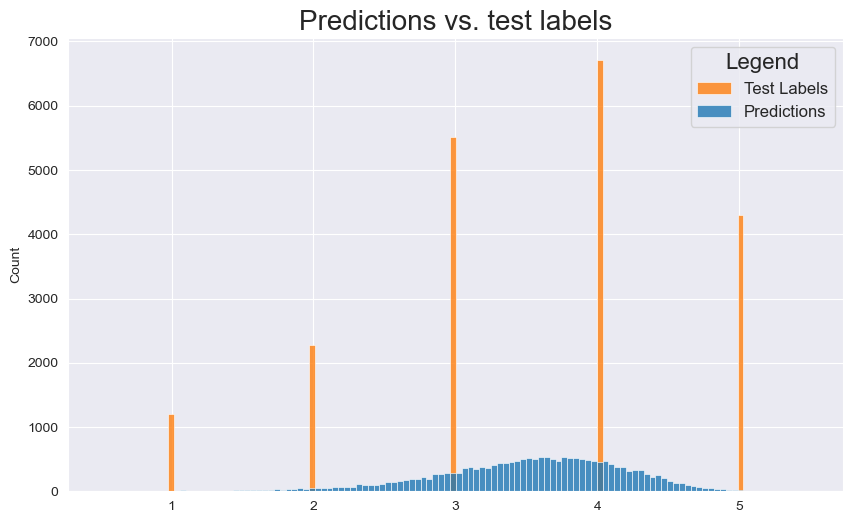

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')

res_data = pd.DataFrame()

# get predictions from cached test 
res_data['predictions'] = model.predict(cached_test)[:, 0]

# get user rating from test dataset
test_labels = []
for r in cached_test:
  test_labels.append((r['user_rating']).numpy())

res_data['test_labels'] = np.concatenate(test_labels)

# plot everythin as kde
plt.figure(figsize=(10,6), dpi=100)
#sns.kdeplot(data=res_data, fill=True, bw_adjust=0.9, alpha=0.6, linewidth=0, legend=False)
sns.histplot(data=res_data, legend=False, alpha=0.8, bins=120)
plt.legend(["Predictions", "Test Labels"][::-1], title="Legend", fontsize=12, title_fontsize=16)
plt.title('Predictions vs. test labels', fontsize=20);

## Testing the ranking model

Now we can test the ranking model by computing predictions for a set of movies and then rank these movies based on the predictions:


In [ ]:
test_ratings = {}
test_movie_titles = ["M*A*S*H (1970)", "Dances with Wolves (1990)", "Speed (1994)"]
for movie_title in test_movie_titles:
  test_ratings[movie_title] = model({
      "user_id": np.array(["42"]),
      "movie_title": np.array([movie_title])
  })

print("Ratings:")
for title, score in sorted(test_ratings.items(), key=lambda x: x[1], reverse=True):
  print(f"{title}: {score}")

## Exporting for serving

The model can be easily exported for serving:


In [ ]:
tf.saved_model.save(model, "export")

We can now load it back and perform predictions:

In [ ]:
loaded = tf.saved_model.load("export")

loaded({"user_id": np.array(["42"]), "movie_title": ["Speed (1994)"]}).numpy()

## Convert the model to TensorFLow Lite

Although TensorFlow Recommenders is primarily designed to perform server-side recommendations, you can still convert the trained ranking model to TensorFLow Lite and run it on-device (for better user privacy privacy and lower latency).


In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model("export")
tflite_model = converter.convert()
open("converted_model.tflite", "wb").write(tflite_model)

Once the model is converted, you can run it like regular TensorFlow Lite models. Please check out [TensorFlow Lite documentation](https://www.tensorflow.org/lite/guide/inference) to learn more.

In [ ]:
interpreter = tf.lite.Interpreter(model_path="converted_model.tflite")
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test the model.
if input_details[0]["name"] == "serving_default_movie_title:0":
  interpreter.set_tensor(input_details[0]["index"], np.array(["Speed (1994)"]))
  interpreter.set_tensor(input_details[1]["index"], np.array(["42"]))
else:
  interpreter.set_tensor(input_details[0]["index"], np.array(["42"]))
  interpreter.set_tensor(input_details[1]["index"], np.array(["Speed (1994)"]))

interpreter.invoke()

rating = interpreter.get_tensor(output_details[0]['index'])
print(rating)

## Next steps

The model above gives us a decent start towards building a ranking system.

Of course, making a practical ranking system requires much more effort.

In most cases, a ranking model can be substantially improved by using more features rather than just user and candidate identifiers. To see how to do that, have a look at the [side features](featurization) tutorial.

A careful understanding of the objectives worth optimizing is also necessary. To get started on building a recommender that optimizes multiple objectives, have a look at our [multitask](multitask) tutorial.